# Sciensus Data Scientist Take Home - Joseph Mills

________________________
***Description:***

This work is focused on demonstrating the full lifecycle of a data project from input, processing, analysis and predictive algorithms using GP Prescription data.

Focus area choice: ***Chapter 8*** of the BNF (British National Formulary) - ***Malignant Disease and Immunosuppression.***

________
_____


***Preface for Hiring Team and Personal Reflection***

*My approach has largely focused on making appropriate decision for the task and to demonstrate a broad range of skills, as the task requires.*

*Through this work I have focused on Ch.8 of the BNF and have specifically chosen anomaly detection using Isolation Forests. This decision was made to limit and focus the EDA and modelling given the scale of the data at hand and to deliver meaningful insight whilst, most likely, being the chapter of most interest to Sciensus.*

*With my previous experience directly relating to classifiers/regression and time series I though best to focus my efforts on anomaly detection. This is in hope both for my personal development and to demonstrate my ability to tackle new-to-me domains and architecture.*

*Any questions, queries or qualms; please do not hesitate to get in-touch*

millsjoseph@live.co.uk


____
___

**Compatability statement;**

 This code runs on Google Colab under the free license.

 The below setting can be set at the top right of the screen.

 Runtime: **python3**


 Hardware Accelerator: **v2-8 TPU**

 note: developed on v6e-1
______

Created: 06/06/2025 Joseph Mills : *Import*

Modified: 07/06/2025 Joseph Mills : *Convert to Polars for more efficient data munge, Pandas for ML. External Data addition, DQ*

Modified: 08/06/2025 Joseph Mills : *Explore scan_ fun^ of polars, Rapids cuDF - descope both for now, run on sample, scale & optimise later*

Modified: 09/06/2025 Joseph Mills : *EDA, Iso-Forrest*
______

____
## High Level Notebook Data Flow
____

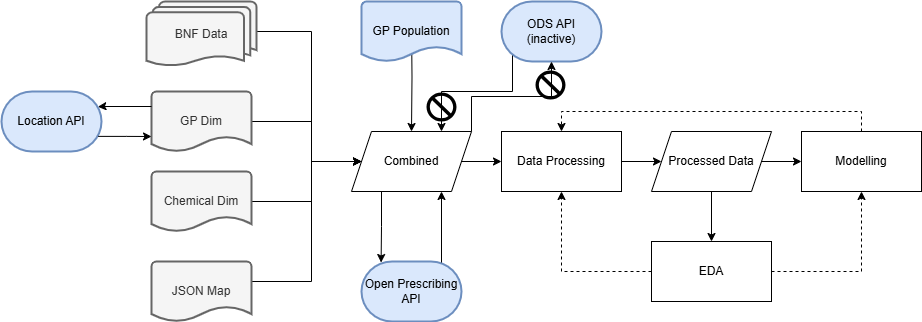

___
## Glossary
___

BNF INFO FROM https://digital.nhs.uk/data-and-information/areas-of-interest/prescribing/practice-level-prescribing-in-england-a-summary/practice-level-prescribing-glossary-of-terms

###***Items***
This gives the number of items for this presentation that were dispensed in the specified month. A prescription item refers to a single supply of a medicine, dressing or appliance prescribed on a prescription form. If a prescription form includes three medicines it is counted as three prescription items.

Item figures do not provide any indication of the length of treatment or quantity of medicine prescribed (the quantity is given in the 'Quantity' field, described below).

Patients with a long term condition usually get regular prescriptions. Whilst many prescriptions are for one month, 28 or 30 days supply, others will be for various lengths of treatment and quantity.

### *Net ingredient cost (NIC)*
This is the basic cost of a drug as used in primary care. This is the cost at list price excluding VAT, i.e. the price listed in the national Drug Tariff or in standard price lists and is not necessarily the price the NHS paid. It does not take into account of any contract prices or discounts, dispensing costs, fees or prescription charge income, so the amount the NHS paid will be different.

NIC is used in Prescription Services reports and other analyses, as it standardises cost throughout prescribing nationally, and allows comparisons of data from different sources. The figures are in pounds and pence.

### ***Actual Cost***
From July 2012 onwards, the formula used to calculate 'Actual Cost' has been changed to include the new reimbursement payments which will be charged back to practices from dispensed prescriptions.

The current formula is:

the NIC less discount
plus payment for consumables (previously known as Container Allowance)
plus payment for Containers
plus Out of Pocket expenses
Prior to July 2012, this Actual Cost was defined as the NIC less the average discount percentage received by pharmacists calculated from the previous month, plus container allowance. This is the estimated cost to the NHS, which is lower than NIC.

Community pharmacists are reimbursed for medicines they have dispensed on the basis of the NIC less a deduction related to the discount that they are assumed to have received from their suppliers (for details see the Drug Tariff Part V - Deduction Scale). A container allowance is then added (see Drug Tariff Part IV). The figures are in pounds and pence.

Note: electronic Drug Tariff can be found at:

https://www.nhsbsa.nhs.uk/pharmacies-gp-practices-and-appliance-contractors/drug-tariff



### ***Quantity***
The quantity of a drug dispensed is measured in units depending on the formulation of the product, which is given in the drug name. Quantities should not be added together across preparations because of different strengths and formulations.

where the formulation is tablet, capsule, ampoule, vial etc the quantity will be the number of tablets, capsules, ampoules, vials etc
where the formulation is a liquid the quantity will be the number of millilitres
where the formulation is a solid form (such as cream, gel, ointment) the quantity will be the number of grammes

### ***BNF CODE STRUCTURE***

This is the BNF code for the drug:

characters 1 and 2 show the BNF chapter
3 and 4 show the BNF section
5 and 6 show the BNF paragraph
7 shows the BNF sub-paragraph
8 and 9 show the chemical substance
10 and 11 show the product
12 and13 show the strength and formulation
14 and 15 show the equivalent
The 'equivalent' is defined as follows:

if the presentation is a generic, the 14th and 15th characters will be the same as the 12th and 13th character
where the product is a brand, the 14th and 15th digit will match that of the generic equivalent, unless the brand does not have a generic equivalent in which case A0 will be

### ***Accuracy***  -- statement from BNF link above
All prescription statistics in this data are based on information systems at NHS Prescription Services, part of the NHS BSA. The figures used are collected as an essential part of the process of reimbursing dispensers (mainly pharmacists and dispensing doctors) for medicines supplied. All prescriptions which are dispensed in England need to be submitted to NHS BSA if the dispenser is to be reimbursed and so coverage should be complete.

NHS Prescription Services quality assures the data they provide. They state that due to the complex and manual processes involved there may be inaccuracies in capturing prescription information which are then reflected in the data. Currently the prescription processing activity is internally audited to 97.5% accuracy (meaning at least 97.5% of prescriptions are recorded accurately). While the BSA can adjust payments to dispensers if an error is identified they are unable to correct the prescribing data.

____

## 1.Set Up

____

In [ ]:
# skip if not running in Google Colab
# if req'd to load checkpoint saved in sec.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install folium

In [ ]:
!pip install kagglehub

In [ ]:
!pip install polars

In [ ]:
!pip install summarytools

In [ ]:
!pip install pgeocode

In [ ]:
# These imports are either installed above or are native to colab.
import os
import json
import requests
import pgeocode
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import glob
import datetime
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary
from kagglehub import KaggleDatasetAdapter

In [ ]:
# download latest version of data from kaggle
path = kagglehub.dataset_download("nhs/general-practice-prescribing-data")

____

### Import Chem Data

____

*The Chemical dataset provides a Parent Chemical name mapping which is useful for aggregating in analysis.*

In [ ]:
#Chem import
chem_df = pl.read_csv(path + '/chem.csv')
nRow, nCol = chem_df.shape
print(f'There are {nRow} rows and {nCol} columns')
assert len(chem_df) == 3487

There are 3487 rows and 2 columns


In [ ]:
chem_df[:3]

CHEM SUB,NAME
str,str
"""0101010A0""","""Alexitol Sodium"""
"""0101010B0""","""Almasilate"""
"""0101010C0""","""Aluminium Hydroxide"""


_____

### Import Practice Data

_____

*The practice data provides valuable meta data of the practices that the BNF data refer to.*

In [ ]:
#Practice import

#does not have field names
column_names = [
    'practice_code' #ODS
    ,'practice_name'
    , 'address_1'
    , 'address_2'
    , 'town'
    , 'region'
    , 'postcode']

prac_df = pl.read_csv(path + '/practices.csv',has_header=False,new_columns=column_names)
nRow, nCol = prac_df.shape
print(f'There are {nRow} rows and {nCol} columns')
assert len(prac_df) == 12020

There are 12020 rows and 7 columns


In [ ]:
prac_df=prac_df.drop(
     'address_1'
    , 'address_2'
    , 'town'
)

In [ ]:
prac_df[:4]

practice_code,practice_name,region,postcode
str,str,str,str
"""A81001""","""THE DENSHAM SURGERY""","""CLEVELAND""","""TS18 1HU"""
"""A81002""","""QUEENS PARK MEDICAL CENTRE""","""CLEVELAND""","""TS18 2AW"""
"""A81003""","""VICTORIA MEDICAL PRACTICE""","""CLEVELAND""","""TS26 8DB"""
"""A81004""","""WOODLANDS ROAD SURGERY""","""CLEVELAND""","""TS1 3BE"""


_____

### Run Postcode Lookup (county_name, lat, long)

_____

*pgeocode does act as an API and is referred to as such above. However, the functionality used here is an offline library, this is to improve DQ for regiona and to plot EDA. *

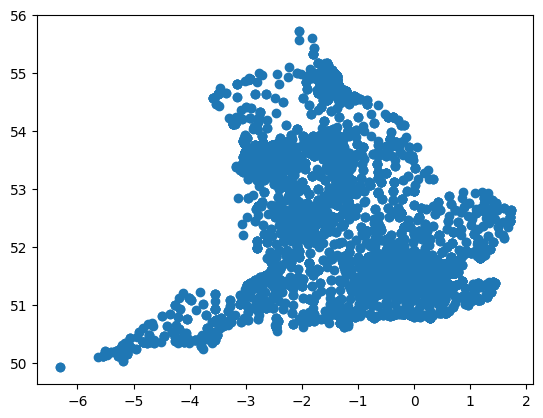

In [ ]:
# distinct postcode list from pracs
distinct_postcodes = prac_df.select("postcode").unique()

nomi = pgeocode.Nominatim('gb') # includes NI e.g. BT93 8AD

#nomi.query_postal_code("BT93 8AD")

pcd_return=nomi.query_postal_code(distinct_postcodes)
pcd_return["postcode"] = distinct_postcodes.get_column("postcode").to_pandas()
pcd_return = pcd_return[[
    "postcode"
    ,"state_name"
    ,"state_code"
    ,"county_name"
    ,"latitude"
    ,"longitude"
]]

#Data is purely England only

plt.scatter(x="longitude", y="latitude", data=pcd_return)

In [ ]:
# Join lat long to master prac file

# Join to add latitude and longitude
pcd_return_pl = pl.from_pandas(pcd_return)
del pcd_return

prac_df_with_coords = prac_df.join(
    pcd_return_pl.select(["postcode", "latitude", "longitude","county_name"]),
    on="postcode",
    how="left"
)
del prac_df

In [ ]:
prac_df_with_coords[:4]

practice_code,practice_name,region,postcode,latitude,longitude,county_name
str,str,str,str,f64,f64,str
"""A81001""","""THE DENSHAM SURGERY""","""CLEVELAND""","""TS18 1HU""",54.5613,-1.3243,"""Durham"""
"""A81002""","""QUEENS PARK MEDICAL CENTRE""","""CLEVELAND""","""TS18 2AW""",54.5613,-1.3243,"""Durham"""
"""A81003""","""VICTORIA MEDICAL PRACTICE""","""CLEVELAND""","""TS26 8DB""",54.7,-1.25,"""Durham"""
"""A81004""","""WOODLANDS ROAD SURGERY""","""CLEVELAND""","""TS1 3BE""",54.5762,-1.2348,"""North Yorkshire"""


___

### GP Registered Population May 2017

___

*GP Practices very largely with regards to the population that they serve. It is therefore vital that any analysis done on GP data is reflective of the population, particularly when considering outliers. Here, GP registration data is retrieved from NHS Digital from May 2017 only. Best practice would be to include multiple months. Later stages of this work, albeit not shown here, highlighted the impact of GP merges/closures/starts on the impact on trends and anomaly detection.*

*There are some missing Practices - which appear to be due to the practice role which may just be cost-centres as discovered in the next API call.*

*ODS note: 'Prescribing cost centre codes not organisation codes, but have been used for many years to identify General Practices and other primary care prescribing settings'*

In [ ]:
# import data from NHSBA/link below
# note: *should* run with each month, but using MAY 17 only here.

!wget -O gp_reg.csv "https://files.digital.nhs.uk/publicationimport/pub23xxx/pub23978/gp-reg-pat-prac-all.csv"

GP_REG = pl.read_csv("gp_reg.csv")

# Preview
GP_REG.head()

--2025-06-09 19:21:17--  https://files.digital.nhs.uk/publicationimport/pub23xxx/pub23978/gp-reg-pat-prac-all.csv
Resolving files.digital.nhs.uk (files.digital.nhs.uk)... 18.239.18.104, 18.239.18.110, 18.239.18.2, ...
Connecting to files.digital.nhs.uk (files.digital.nhs.uk)|18.239.18.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549227 (536K) [text/csv]
Saving to: ‘gp_reg.csv’

gp_reg.csv          100%[===================>] 536.35K  --.-KB/s    in 0.02s   

2025-06-09 19:21:17 (24.5 MB/s) - ‘gp_reg.csv’ saved [549227/549227]



PUBLICATION,EXTRACT_DATE,TYPE,CCG_CODE,ONS_CCG_CODE,CODE,POSTCODE,SEX,AGE,Number of patients
str,str,str,str,str,str,str,str,str,i64
"""GP_PRAC_PAT_LIST""","""01MAY2017""","""GP""","""00C""","""E38000042""","""A83005""","""DL1 3RT""","""ALL""","""ALL""",11673
"""GP_PRAC_PAT_LIST""","""01MAY2017""","""GP""","""00C""","""E38000042""","""A83006""","""DL3 6HZ""","""ALL""","""ALL""",7954
"""GP_PRAC_PAT_LIST""","""01MAY2017""","""GP""","""00C""","""E38000042""","""A83010""","""DL3 9JP""","""ALL""","""ALL""",14283
"""GP_PRAC_PAT_LIST""","""01MAY2017""","""GP""","""00C""","""E38000042""","""A83013""","""DL1 4YL""","""ALL""","""ALL""",11192
"""GP_PRAC_PAT_LIST""","""01MAY2017""","""GP""","""00C""","""E38000042""","""A83031""","""DL3 8SQ""","""ALL""","""ALL""",9954


In [ ]:
prac_df_final = prac_df_with_coords.join(
    GP_REG.select(["CODE","Number of patients"])
    ,left_on="practice_code"
    ,right_on="CODE"
    ,how="left"
)

In [ ]:
prac_df_final[:2]

practice_code,practice_name,region,postcode,latitude,longitude,county_name,Number of patients
str,str,str,str,f64,f64,str,i64
"""J84017""","""MEDINA HEALTHCARE""","""ISLE OF WIGHT""","""PO30 1PR""",50.684165,-1.328915,"""Isle of Wight""",8746
"""G82658""","""SELLINDGE SURGERY""","""KENT""","""TN25 6JX""",51.146426,0.939361,"""Kent""",4780


In [ ]:
prac_df_final=prac_df_final.unique()

In [ ]:
#prac_df pop tot
print(prac_df_final['Number of patients'].sum())


63358468



*As a sense check, here there are 63 Million registered people. In the UK, according to ONS is approx.56 million for 2017. This discrepency can be due to individuals listed under multiple GP practices (e.g. students) or delayed reporting.*

____
### !DNU - to revisit if reqd:  ODS API Call for Practice ***role***
_____


This code was to address the missing practice data that could deem valuable when comparing prescribing data. As mentioned above, some practices are cost centres as was discovered below and manually through ODS online. Given the limited volume and runtime of the below this has been commented-out to ensure progress with the analysis. This would be a good feature to explore in the future.

In [ ]:
## ODS: 'Prescribing cost centre codes not organisation codes, but have been used for many years to identify General Practices and other primary care prescribing settings
## therefore not completing below due to further domain research required (if required)

#distinct_practice_code = prac_df_final.select("practice_code").unique().to_series().to_list()
#https://directory.spineservices.nhs.uk/ORD/2-0-0/organisations/Y04982?

# Store
#results = []
#def extract_roles(response_json):
#    roles = response_json.get("Organisation", {}).get("Roles", {}).get("Role", [])
#
#    primary_role = None
#    secondary_roles = []###
#
#    for role in roles:
#        role_id = role.get("id")
#        if role.get("primaryRole", False):
#            primary_role = role_id
#        else:
#            if role_id:
#                secondary_roles.append(role_id)#
#
#    return primary_role, secondary_roles
#
#for code in distinct_practice_code:
#    url = f"https://directory.spineservices.nhs.uk/ORD/2-0-0/organisations/{code}"
#    try:
#        response = requests.get(url, timeout=5)
#        if response.status_code == 200:
#            data = response.json()
#            primary, secondary = extract_roles(data)
#            results.append({
#                "practice_code": code,
#                "primary_role": primary,
#                "secondary_roles": secondary
#            })
#        else:
#            results.append({
#                "practice_code": code,
#                "primary_role": None,
#                "secondary_roles": None
#            })
#    except Exception:
#        results.append({
#            "practice_code": code,
#            "primary_role": None,
#            "secondary_roles": None
#        })

In [ ]:
# 2340 reqests - 14mins

____
### Import BNF files
______

The BNF Files are 13 monthly files dating between May 2016 and May 2017. The size of these files has a grand total of 131,004,583 records and subsequently required greater consideration in data handling and processing for computation efficiency.

Here, polars, having a rust backend provide far greater efficiency in storage and processing. Greater improvements could be made, even within polars, using functions like scan_csv/scan_parquet. Other optimisation, such as only joing meta data/increase data, could be made far later in the process also.

Given the data is by months, date has been set to the first of the month with the caveat that it is likely that data covers the entire month. BNF documentation confirms this. For processing ease, this has remained unchanged.

In [ ]:
csv_files = glob.glob(os.path.join(path, '*BNFT.csv'))
len(csv_files) # should be 13
assert len(csv_files) == 13

In [ ]:
# Prescribing data
## inspection on kaggle proves consistent file structure

df_list = []


# Loop through each file
for file in csv_files:
    # Read CSV
    df = pl.read_csv(file)
    #df = pl.read_csv(file,n_rows=10000)


    # Add 'file' column
    file_name = os.path.basename(file)
    date_str = file_name[1:7]  # Extract YYYYMM
    df = df.with_columns([
        #pl.lit(file_name).alias("file"),
        pl.lit(date_str).str.strptime(pl.Date, format="%Y%m").alias("date")
    ])

    print(f"{file_name}: {df.shape[0]} rows, {df.shape[1]} columns")
    df_list.append(df)

# Join together
combined_df = pl.concat(df_list, how="vertical")


print(f"\nCombined DataFrame: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")

T201605PDPI+BNFT.csv: 10096213 rows, 8 columns
T201702PDPI+BNFT.csv: 9797396 rows, 8 columns
T201703PDPI+BNFT.csv: 10281050 rows, 8 columns
T201609PDPI+BNFT.csv: 10143634 rows, 8 columns
T201701PDPI+BNFT.csv: 10016344 rows, 8 columns
T201704PDPI+BNFT.csv: 9771989 rows, 8 columns
T201607PDPI+BNFT.csv: 10154513 rows, 8 columns
T201610PDPI+BNFT.csv: 10038649 rows, 8 columns
T201611PDPI+BNFT.csv: 10164807 rows, 8 columns
T201705PDPI+BNFT.csv: 10116390 rows, 8 columns
T201606PDPI+BNFT.csv: 10240053 rows, 8 columns
T201612PDPI+BNFT.csv: 10113965 rows, 8 columns
T201608PDPI+BNFT.csv: 10069580 rows, 8 columns

Combined DataFrame: 131004583 rows, 8 columns


In [ ]:
combined_df[:4]
assert len(combined_df) == 131004583

____
### Import BNF JSON
____


*As mentioned above, the file sizes can get very large, very quickly.*

*The author of the data in kaggle, mindful of this, split the data into dimension tables/mappings.*

*Here; he Kaggle Data set comes with a dictionary in JSON format. The data is stored efficiently using keys and a JSON for the mapping. Here the mapping is provided for better EDA, and for BNF parsing.*

*The JSON provides, BNF Drug Code, BNF Drug Name  and ODS GP Practice.*

In [ ]:
# Import BNF Map JSON
with open(path + '/column_remapping.json', 'r') as f:
    bnf_map = json.load(f)

In [ ]:
bnf_value = bnf_map["bnf_code"].get("17512", "Not found")
#bnf_code, bnf_name, practice
bnf_value


'0401010Z0AAAAAA'

In [ ]:
#creating polars lookup dataframes
bnf_code_lookup_df = pl.DataFrame([
{"bnf_code": k, "bnf_code2": v}
    for k, v in bnf_map["bnf_code"].items()
])
bnf_name_lookup_df = pl.DataFrame([
{"bnf_name": k, "bnf_name2": v}
    for k, v in bnf_map["bnf_name"].items()
])

bnf_practice_lookup_df = pl.DataFrame([
{"bnf_practice": k, "bnf_practice2": v}
    for k, v in bnf_map["practice"].items()
])

bnf_code_lookup_df[:2]

bnf_code,bnf_code2
str,str
"""0""","""091200000BFMBDG"""
"""1""","""1501041T0AAATAT"""


____
____

## 2.Data Joins and Open Prescribing API
___


### Open Prescribing API test

____

Given Open Prescribing offer a robust and extensive API, it was considered using this to validate/enrich the BNF data already provided.

This is possible but given the run-time, this has not been continued within the analysis.

In [ ]:
#BNF OP API lookup check

bnf_code = "0401010Z0AAAAAA"

url = "https://openprescribing.net/api/1.0/bnf_code/"

# params
params = {
    "q": bnf_code,
    "exact": "true",  #returns exact code info #false returns All chemicals and presentations matching a code:
    "format": "json"
}

response = requests.get(url, params=params)

# return
if response.status_code == 200:
    data = response.json()
    if data:
        print(data[0])  # The matched BNF entry
    else:
        print("No data found for this BNF code.")
else:
    print(f"Error {response.status_code}: {response.text}")

{'type': 'product format', 'id': '0401010Z0AAAAAA', 'name': 'Zopiclone 7.5mg tablets', 'is_generic': True}


____

### Join BNF Dict

____

*The Kaggle Data set comes with a dictionary in JSON format. The data is stored efficiently using keys and a JSON for the mapping. Here the mapping is provided for better EDA, and for BNF parsing.*

*The JSON provides, BNF Drug Code, BNF Drug Name  and ODS GP Practice.*

In [ ]:
# Join BNF dict to main data #possible efficiency saving here

combined_df = combined_df.with_columns(
    pl.col("practice","bnf_code","bnf_name").cast(pl.Utf8)  # ensure it's a string
)


combined_df = combined_df.join(
    bnf_code_lookup_df
    ,left_on="bnf_code"
    ,right_on = "bnf_code"
    ,how="left"
)

combined_df = combined_df.join(
    bnf_name_lookup_df
    ,left_on="bnf_name"
    ,right_on="bnf_name"
    ,how="left"
)
combined_df = combined_df.join(
    bnf_practice_lookup_df
    ,left_on="practice"
    ,right_on="bnf_practice"
    ,how="left"
)

combined_df=combined_df.drop(
    "practice"
    ,"bnf_code"
    ,"bnf_name"
)

In [ ]:
combined_df[:4]

items,nic,act_cost,quantity,date,bnf_code2,bnf_name2,bnf_practice2
i64,f64,f64,i64,date,str,str,str
2,44.1,40.84,189,2016-05-01,"""0703010F0BLAAAJ""","""Yasmin_Tab""","""Y05218"""
2,1.64,1.64,35,2016-05-01,"""0401010Z0AAAAAA""","""Zopiclone_Tab 7.5mg""","""Y04937"""
1,1.26,1.28,42,2016-05-01,"""0401020K0AAAHAH""","""Diazepam_Tab 2mg""","""Y04937"""
2,0.86,1.02,42,2016-05-01,"""0402010ABAAABAB""","""Quetiapine_Tab 25mg""","""Y04937"""


____

### Join Practice Data

____

In [ ]:
# Join Practice Data

combined_df = combined_df.join(
    prac_df_final
    ,left_on="bnf_practice2"
    ,right_on="practice_code"
    ,how="left"
)

___

### BNF Parse

___

As in the glossary, the BNF Code itself holds a wealth of information  as per https://www.bennett.ox.ac.uk/blog/2017/04/prescribing-data-bnf-codes/
and cross-referenced with https://digital.nhs.uk/data-and-information/areas-of-interest/prescribing/practice-level-prescribing-in-england-a-summary/practice-level-prescribing-glossary-of-terms

*This has been included to support analysis and filter by chapter.*

In [ ]:
#Substring parsing
combined_df = combined_df.with_columns([
    pl.col("bnf_code2").str.slice(0, 2).alias("bnf_chapter"),
    pl.col("bnf_code2").str.slice(2, 2).alias("bnf_section"),
    pl.col("bnf_code2").str.slice(4, 2).alias("bnf_paragraph"),
    pl.col("bnf_code2").str.slice(6, 1).alias("bnf_sub_paragraph"),
    pl.col("bnf_code2").str.slice(7, 2).alias("bnf_chemical_substance"),
    pl.col("bnf_code2").str.slice(9, 2).alias("bnf_product"),
    pl.col("bnf_code2").str.slice(11, 2).alias("bnf_strength_formulation"),
    pl.col("bnf_code2").str.slice(13, 2).alias("bnf_generic_equivalent")
])

_____
_____

## 3.Data Prep

Data Quality Notes;

- DQ is relatively good.
- County_Name to be used as per df summary - only 151 missing vs 193000 for region from origin prac lookup this is because  151 missing from Bristol BS14 7AA - imputed 'County of Bristol' into county_name and ave bristol lat, long. This improves region analysis drasticaly.

- Only 1% of total records have not matching pop data - may be due to cost centre regional codes; these will be aggregated to county via postcode for this analysis. These have been ignored later in analysis for now, future work would work to incorporate these with enriched data.

- BNF data (items, nic, act_cost, quantity) to be reviewed in Section 5

- Main Assumption is that BNF reporting is ground-truth, anomolies detected to be reported back to relevant gp_prac/pcn's to either be corrected/investigated.

- BNF outlier (if any) to be handled in section 5

- There is further pre-processing in section 5

_______
### Dupes
_______


In [ ]:
duplicates = combined_df.filter(combined_df.is_duplicated())
# Step 3: Show or count duplicates
print(f"Number of duplicate rows: {duplicates.shape[0]}")
assert duplicates.shape[0] == 0

Number of duplicate rows: 0


____
### Filter to Ch8 Malignant Disease and Immunosuppression
____


In [ ]:
filtered_df = combined_df.filter(pl.col("bnf_chapter") == "08")
del combined_df

In [ ]:
len(filtered_df)

1393116

___

### Open Prescribing Check - do-not-run

____

*As per the above Open Prescribing API Test - the run time surpasses the scope of this work.*

*Efficiencies could be made with async or alike- but for now this isn't in-scope.*

*This was by means of checking valid drug data/enriching data.*

*The below still runs by means of demonstration on a sample of 20 records*

In [ ]:

bnf_codes = filtered_df.select("bnf_code2").unique().to_series().to_list()

# Prepare list to hold missing codes
missing_codes = []

# API endpoint
url = "https://openprescribing.net/api/1.0/bnf_code/"

# Loop over codes
for code in bnf_codes[:20]:
    params = {
        "q": code,
        "exact": "true",
        "format": "json"
    }

    try:
        response = requests.get(url, params=params, timeout=5)
        if response.status_code == 200:
            data = response.json()
            if not data:  # Empty result
                missing_codes.append(code)
        else:
            print(f"Error {response.status_code} for {code}")
    except Exception as e:
        print(f"Request failed for {code}: {e}")
        missing_codes.append(code)


print(f"\n{len(missing_codes)} missing BNF codes:")
print(missing_codes)


1 missing BNF codes:
['0802040M0BDABAH']


____
### Join Chem Data (avoids exploding data storage)
____


*Chemical Parent data has been joined later on, as to avoid unnecessary data storage requirements only. The same approach could have been taken for practice data.*

In [ ]:
## Join Chem Data here
filtered_df = filtered_df.with_columns(
    pl.col("bnf_code2").str.slice(0, 9).alias("bnf_code_chem_sub")
)
filtered_df2 = filtered_df.join(
    chem_df
    ,left_on="bnf_code_chem_sub"
    ,right_on="CHEM SUB"
    ,how="left"
)

____

### DF summary

____

*DF Summary is a useful tool in visualising and highlighting the missing, distinct and shape of features as so far. It is the first step of the EDA and is listed here as to address any issues sooner.*

In [ ]:
df_pandas = filtered_df2.to_pandas()
dfSummary(df_pandas)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,items[int64],Mean (sd) : 3.7 (5.0)min < med < max:1.0 < 2.0 < 100.0IQR (CV) : 3.0 (0.7),90 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAetJREFUeJzt18Fu2lAQRuGZQpAJqi2EZHY8QhYseYg8bLbd+1kQkgXXwsExsm523VQp4VLa/u351p6RJR/Z1x5jNOBv9+VP3wDwGeNLF7j71Mwmifv7GOMpcRb47qehuvt0sVg853k+T1neNM3e3V+IFbe69Ead5Hk+32w2p6IoumsWhxCyqqrmdV1PzIxQcZOLn34zs6IourIsXxP2TxNmgB/wMwUJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJ43suH4bhwcxyd09d0ccYT7/wliDqbqG2bftwPp+fVqvVaDQadSk7mqbZu/sLseJuofZ9P86y7HG9XnfL5XJ/7XwIIauqal7X9cTMCPU/d9dPv5nZbDbryrJ8TZkdhiG39KMDx4Z/yKdCDSFk1y4+Ho+ZmVnbttlut3u8dn673X695ehwOByO7v7NzJKOHfjt3mKMHz6rdyW8blmcg0KOAAAAAElFTkSuQmCC"">",0(0.0%)
2,nic[float64],Mean (sd) : 146.5 (306.8)min < med < max:0.0 < 42.2 < 20445.0IQR (CV) : 138.4 (0.5),"20,313 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAWlJREFUeJzt109qAjEYh+GkiOhmBhE8jIfoYXsIbyMlLqotSLrrptQ/46L90efZJvnI4mWG1N57gb/u6bcvALeYXdtQa12WUuYT53/03o8Tz8KXi6HWWpfr9fp5GIbVlOGHw+G11voiVh517Ys6H4Zhtd1uj+M4nu4Z3Fpb7Ha71X6/n5dShMpDrv76SyllHMfTZrN5mzB/OeEMfOMxRQShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRJjdsqm1trh3cGttcT6fZ6WUodZ698X4d95776efFj8Be/ct8q45XZ8AAAAASUVORK5CYII="">",0(0.0%)
3,act_cost[float64],Mean (sd) : 135.8 (284.2)min < med < max:0.1 < 39.5 < 18924.7IQR (CV) : 128.1 (0.5),"41,501 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAWlJREFUeJzt109qAjEYh+GkiOhmBhE8jIfoYXsIbyMlLqotSLrrptQ/46L90efZJvnI4mWG1N57gb/u6bcvALeYXdtQa12WUuYT53/03o8Tz8KXi6HWWpfr9fp5GIbVlOGHw+G11voiVh517Ys6H4Zhtd1uj+M4nu4Z3Fpb7Ha71X6/n5dShMpDrv76SyllHMfTZrN5mzB/OeEMfOMxRQShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRJjdsqm1trh3cGttcT6fZ6WUodZ698X4d95776efFj8Be/ct8q45XZ8AAAAASUVORK5CYII="">",0(0.0%)
4,quantity[int64],Mean (sd) : 159.9 (244.4)min < med < max:0.0 < 80.0 < 12730.0IQR (CV) : 168.0 (0.7),"2,586 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAWlJREFUeJzt109qAjEYh+GkiOhmBhE8jIfoYXsIbyMlLqotSLrrptQ/46L90efZJvnI4mWG1N57gb/u6bcvALeYXdtQa12WUuYT53/03o8Tz8KXi6HWWpfr9fp5GIbVlOGHw+G11voiVh517Ys6H4Zhtd1uj+M4nu4Z3Fpb7Ha71X6/n5dShMpDrv76SyllHMfTZrN5mzB/OeEMfOMxRQShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRJjdsqm1trh3cGttcT6fZ6WUodZ698X4d95776efFj8Be/ct8q45XZ8AAAAASUVORK5CYII="">",0(0.0%)
5,date[datetime64[ms]],Min: 2016-05-01Max: 2017-05-01Duration: 365 days,13 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAARVJREFUeJzt3FEKgkAUQNGKtteaxDW5QNtACQ14szznV5ABr2/+3nVd1wsUbt

___
### Address Missing PCD match
___

*As above, one GP in bristol has it's data imputed below using county average lat/long.*

In [ ]:
missing_county = filtered_df2.filter(pl.col("county_name").is_null())

In [ ]:
#missing_county ## all relate to bristol inactive postcode BS174AA
## filter for bristol - imput county_name = bristol, lat+long as bristol ave
df_bs174 = filtered_df2.filter(pl.col("county_name").str.contains("Bristol"))
latit=df_bs174['latitude'].mean()
longit=df_bs174['longitude'].mean()
print('Bristol',latit,longit)


Bristol 51.46729215886939 -2.579581820175439


In [ ]:
filtered_df2 = filtered_df2.with_columns([
    pl.when(pl.col("postcode").str.contains("BS17 4"))
      .then(pl.lit('County of Bristol'))
      .otherwise(pl.col("county_name"))
      .alias("county_name"),

    pl.when(pl.col("postcode").str.contains("BS17 4"))
      .then(latit)
      .otherwise(pl.col("latitude"))
      .alias("latitude"),

    pl.when(pl.col("postcode").str.contains("BS17 4"))
      .then(longit)
      .otherwise(pl.col("longitude"))
      .alias("longitude")
])

____
____
## Closing Remarks
____


The work above appears to be of value in identifying trends across a 13 month period for Ch8. Analysis over multiple years, removing seasonality could prove fruitful in identifying changing population need/costs.

The anomaly model appears to accurately identify curious records when considering the form, item, quatity and price alone in relation to registered population.

By improving the GP data and enriching the data with drug alternatives. This modelling approach could prove effective in either identify incorrect/dq issues or alternatively suggesting alternative drug brand/formulation for cost saving.
